In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import load_W
from epi.util import pairplot

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/Fig3/"

In [3]:
lb_h = 0.*np.ones((4,))
ub_h = 25.*np.array([1., 1., 1., 1.])

lb_dh = -10.
ub_dh = 10.

h = Parameter("h", 4, lb=lb_h, ub=ub_h)
dh = Parameter("dh", 1, lb=lb_dh, ub=ub_dh)
parameters = [h, dh]

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [4]:
name = "SSSN_SVflip_eps"
parameters = [h, dh]
model = Model(name, parameters)

In [5]:
import tensorflow as tf

V_INIT = tf.constant(-65.*np.ones((1,4,1)), dtype=np.float32)

k = 0.3
n = 2.
v_rest = -70.

dt = 0.005

N = 5
T = 100

def euler_sim_stoch(f, x_init, dt, T):
    x = x_init
    for t in range(T):
        x = x + f(x) * dt
    return x[:, :, :, 0]

def euler_sim_stoch_traj(f, x_init, dt, T):
    x = x_init
    xs = [x_init]
    for t in range(T):
        x = x + f(x) * dt
        xs.append(x)
    return tf.concat(xs, axis=3)

def f_r(v):
    return k*(tf.nn.relu(v-v_rest)**n)

In [6]:
def SSSN_sim(h):
    h = h[:,None,:,None]

    W = load_W()
    sigma_eps = 0.2*np.array([1., 0.5, 0.5, 0.5])
    tau = np.array([0.02, 0.01, 0.01, 0.01])
    tau_noise = np.array([0.05, 0.05, 0.05, 0.05])

    W = W[None,:,:,:]
    sigma_eps = sigma_eps[None,None,:,None]
    tau = tau[None,None,:,None]
    tau_noise = tau_noise[None,None,:,None]

    _v_shape = tf.ones((h.shape[0], N, 4, 1), dtype=tf.float32)
    v_init = _v_shape*V_INIT
    eps_init = 0.*_v_shape
    y_init = tf.concat((v_init, eps_init), axis=2)

    def f(y):
        v = y[:,:,:4,:]
        eps = y[:,:,4:,:]
        B = tf.random.normal(eps.shape, 0., np.sqrt(dt))

        dv = (-v + v_rest + h + eps + tf.matmul(W, f_r(v))) / tau
        deps = (-eps + (np.sqrt(2.*tau_noise)*sigma_eps*B/dt)) / tau_noise

        return tf.concat((dv, deps), axis=2)

    v_ss = euler_sim_stoch(f, y_init, dt, T)
    return v_ss

diff_prod_mean = -.25
diff_sum_mean = 0.
def SV_flip(h, dh):
    dh_pattern = tf.constant(np.array([[1., 1., 0., 0.]], dtype=np.float32))
    dh = dh*dh_pattern

    ss1 = tf.reduce_mean(f_r(SSSN_sim(h)[:,:,:4]), axis=1)
    ss2 = tf.reduce_mean(f_r(SSSN_sim(h+dh)[:,:,:4]), axis=1)

    diff1 = (ss1[:,2]-ss1[:,3]) / tf.norm(ss1, axis=1, keepdims=False)
    diff2 = (ss2[:,2]-ss2[:,3]) / tf.norm(ss2, axis=1, keepdims=False)
    diff_prod = diff1*diff2
    T_x = tf.stack((diff_prod,
                    (diff_prod - diff_prod_mean) ** 2), axis=1)

    return T_x

model.set_eps(SV_flip)


In [7]:
epi_df = model.get_epi_df()
epi_df['N'] = [al_hps['N'] for al_hps in epi_df['AL_hps']]
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['mu'] = [ep['mu'] for ep in epi_df['EP']]
epi_df['random_seed'] = [arch['random_seed'] for arch in epi_df['arch']]

# select by c0
epi_df = epi_df[(epi_df['c0']==1.) & (epi_df['N']==100)]


# Emergent property values.
diff_prod_mean = -0.25
mu = np.array([diff_prod_mean, (diff_prod_mean/2.)**2])
print(diff_prod_mean)
has_mu = []
for _mu in epi_df['mu']:
    if _mu.shape[0] == mu.shape[0]:
        has_mu.append(np.isclose(_mu, mu).all())
    else:
        has_mu.append(False)
epi_df = epi_df[has_mu]

paths = sorted(epi_df['path'].unique())
for i, path in enumerate(paths):
    print(i, path)


-0.25
0 data/epi/SSSN_SVflip_eps/d415efc3996031ee8b9d43a9001d380f/D5_C3_L2_U50_bnmom=9.90E-01_PA_rs1/dcf451239220a25d6c6df78333aff836/N100_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00
1 data/epi/SSSN_SVflip_eps/d415efc3996031ee8b9d43a9001d380f/D5_C3_L2_U50_bnmom=9.90E-01_PA_rs2/dcf451239220a25d6c6df78333aff836/N100_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00
2 data/epi/SSSN_SVflip_eps/d415efc3996031ee8b9d43a9001d380f/D5_C3_L2_U50_bnmom=9.90E-01_PA_rs3/dcf451239220a25d6c6df78333aff836/N100_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00


In [8]:
"""for path in paths:
    epi_df2 = epi_df[epi_df['path'] == path]
    print(epi_df2.loc[0, ['c0','random_seed']])
    epi_df2.plot('iteration', 'H')
    plt.show()
    Rs = ['R%d' % r for r in range(1,3)]
    epi_df2.plot('iteration', Rs)
    plt.plot([0, epi_df2['iteration'].max()], [0, 0], 'k--')
    plt.show()"""

"for path in paths:\n    epi_df2 = epi_df[epi_df['path'] == path]\n    print(epi_df2.loc[0, ['c0','random_seed']])\n    epi_df2.plot('iteration', 'H')\n    plt.show()\n    Rs = ['R%d' % r for r in range(1,3)]\n    epi_df2.plot('iteration', Rs)\n    plt.plot([0, epi_df2['iteration'].max()], [0, 0], 'k--')\n    plt.show()"

In [9]:
best_Hs = []
convergeds = []
best_ks = []
for i, path in enumerate(paths):
    if i in [0, 1]:
        best_Hs.append(np.nan)
        convergeds.append(False)
        best_ks.append(np.nan)
        continue
        
    epi_df2 = epi_df[epi_df['path'] == path]
    df_row = epi_df2.iloc[0]
    init = df_row['init']
    init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
    nf = model._df_row_to_nf(df_row)
    aug_lag_hps = model._df_row_to_al_hps(df_row)
    best_k, converged, best_H = model.get_convergence_epoch(init_params, nf, mu, aug_lag_hps, 
                                    alpha=0.05, nu=0.25)
    print(best_k, best_H)
    best_Hs.append(best_H)
    convergeds.append(converged)
    best_ks.append(best_k)
    
bestHs = np.array(best_Hs)
best_ks = np.array(best_ks)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
0.79_0.17
8 9.947428


In [10]:
best_Hs = np.array([x if x is not None else np.nan for x in best_Hs])
ind = np.nanargmax(best_Hs)
path = paths[ind]
best_k = int(best_ks[ind])
best_H = best_Hs[ind]

2
data/epi/SSSN_SVflip_eps/d415efc3996031ee8b9d43a9001d380f/D5_C3_L2_U50_bnmom=9.90E-01_PA_rs3/dcf451239220a25d6c6df78333aff836/N100_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00


In [11]:
epi_df2 = epi_df[epi_df['path'] == path]
df_row = epi_df2.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

ckpt_dir data/epi/SSSN_SVflip_eps/d415efc3996031ee8b9d43a9001d380f/D5_C3_L2_U50_bnmom=9.90E-01_PA_rs3/dcf451239220a25d6c6df78333aff836/N100_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00
os list ['ckpt-4.data-00000-of-00001', 'ckpt-5.data-00000-of-00001', 'ckpt-6.data-00000-of-00001', 'ckpt-7.data-00000-of-00001', 'epi_opt.mp4', 'checkpoint', 'ckpt-1.data-00000-of-00001', 'ckpt-0.data-00000-of-00001', 'ckpt-3.data-00000-of-00001', 'ckpt-2.data-00000-of-00001', 'ckpt-8.index', 'movie_data.npz', 'opt_data.csv', 'ckpt-8.data-00000-of-00001', 'ckpt-2.index', 'ckpt-0.index', 'ckpt-4.index', 'opt_data.npz', 'ckpt-6.index', 'ckpt-1.index', 'ckpt-3.index', 'AL_hps.pkl', 'ckpt-7.index', 'ckpt-5.index']


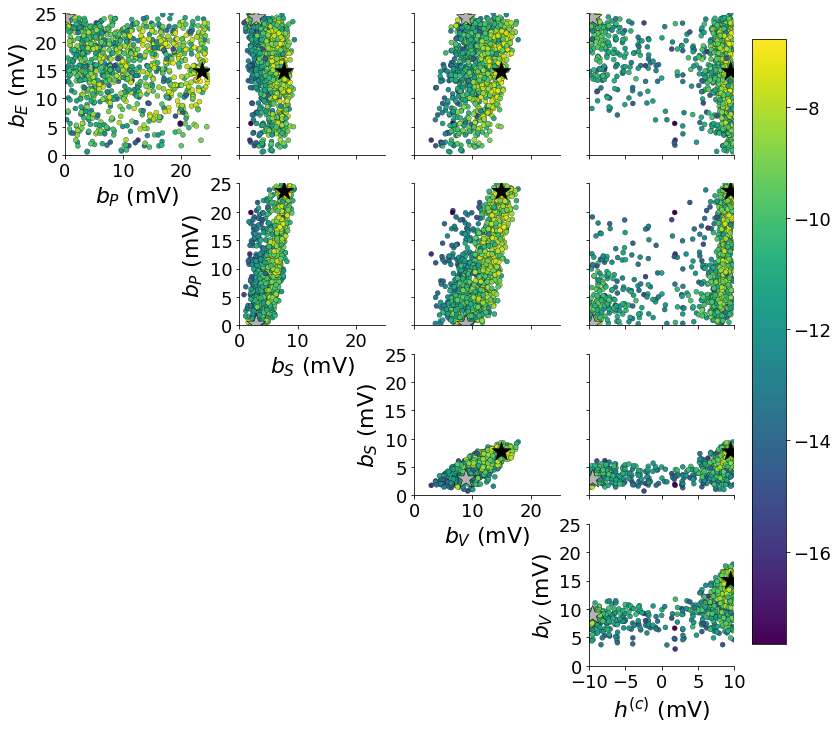

In [12]:
M = 1000
s = 25

z, log_q_z = dist.nf(M)
z = z.numpy()
log_q_z = log_q_z.numpy()

z1 = z[z[:,4] > 0., :]
log_q_z1 = log_q_z[z[:,4] > 0.]
z2 = z[z[:,4] < 0., :]
log_q_z2 = log_q_z[z[:,4] < 0.]
z_mode1 = z1[np.argmax(log_q_z1)][None,:]
z_mode2 = z2[np.argmax(log_q_z2)][None,:]
z_modes = np.concatenate((z_mode1, z_mode2), axis=0)
np.savez('SV_mode.npz', z_mode1=z_mode1, z_mode2=z_mode2)

alpha_c_star = 1.
c_star = [np.concatenate((np.array([0,0,0]), np.array([alpha_c_star]))),
             np.concatenate((.7*np.ones((3,)), np.array([alpha_c_star])))]


neurons = [alpha for alpha in neuron_inds.keys()]
labels = [r'$b_%s$ (mV)' % alpha for alpha in neurons]
labels += [r'$h^{(c)}$ (mV)']
fig, axs, = pairplot(z, range(5), labels, s=s,
                     fontsize=22, lb=dist.nf.lb, ub=dist.nf.ub,
                     c=log_q_z, c_label='',
                     starred=z_modes, c_starred=c_star)
plt.savefig(figdir + 'SV_flip_z.png')

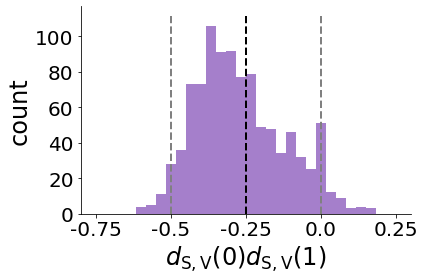

In [135]:
from epi.util import plot_T_x

T_x = model.eps(z).numpy()
xlabel = r"$d_{\mathregular{S,V}}(0)d_{\mathregular{S,V}}(1)$"
plot_T_x(None, T_x[:,0],
         x_mean = mu[0], x_std = np.sqrt(mu[1]),
         xlabel=xlabel, fontsize=24)
plt.tight_layout()
plt.savefig(figdir + 'SVflip_Tx1.png')

In [133]:
def SSSN_sim_traj(h, N=20, dt=0.005, T=100):
    h = h[:,None,:,None]

    W = load_W()
    sigma_eps = 0.2*np.array([1., 0.5, 0.5, 0.5])
    tau = np.array([0.02, 0.01, 0.01, 0.01])
    tau_noise = np.array([0.05, 0.05, 0.05, 0.05])

    W = W[None,:,:,:]
    sigma_eps = sigma_eps[None,None,:,None]
    tau = tau[None,None,:,None]
    tau_noise = tau_noise[None,None,:,None]
   
    _v_shape = tf.ones((h.shape[0], N, 4, 1), dtype=tf.float32)
    v_init = _v_shape*V_INIT
    eps_init = 0.*_v_shape
    y_init = tf.concat((v_init, eps_init), axis=2)
    
    def f(y):
        v = y[:,:,:4,:]
        eps = y[:,:,4:,:]
        B = tf.random.normal(eps.shape, 0., np.sqrt(dt))
       
        dv = (-v + v_rest + h + eps + tf.matmul(W, f_r(v))) / tau
        deps = (-eps + (np.sqrt(2.*tau_noise)*sigma_eps*B/dt)) / tau_noise
        
        return tf.concat((dv, deps), axis=2)
        
    v_t = euler_sim_stoch_traj(f, y_init, dt, T)
    
    return v_t

def SSSN_stats(h, N=20, dt=0.005, T=100):
    v_t = SSSN_sim_traj(h, N=N, dt=dt, T=T)[:,:,:4,:]
    r_t = f_r(v_t)
    avg_r = tf.reduce_mean(r_t[:,:,:,(T//2):], axis=3)
    var_r = tf.math.reduce_std(r_t[:,:,:,(T//2):], axis=3)**2
    
    mean_avg_r = tf.reduce_mean(avg_r, axis=1)
    stderr_avg_r = tf.math.reduce_std(avg_r, axis=1) / np.sqrt(N)
    mean_var_r = tf.reduce_mean(var_r, axis=1)
    stderr_var_r = tf.math.reduce_std(var_r, axis=1) / np.sqrt(N)
    
    return tf.concat((mean_avg_r, stderr_avg_r, mean_var_r, stderr_var_r), axis=1)

def plot_responses(z, N=20, dt=0.005, T=100, name='', fontsize=14):
    h = z[:4]
    dh = z[4]
    gamma = np.concatenate((np.array([0., 1.]), np.linspace(0., 1., 51)), axis=0)
    dh_pattern = tf.constant(np.array([[1., 1., 0., 0.]], dtype=np.float32))
    _h = h + dh*gamma[:,None]*dh_pattern
    dt_sim = 0.001
    T_sim = 500
    v_t = SSSN_sim_traj(_h, N=1, dt=dt_sim, T=T_sim).numpy()
    T_x = SSSN_stats(_h, N=N, dt=dt, T=T)
    
    t = dt_sim*np.arange(T_sim+1)
   
    linetypes = ['-', '--']
    fig, ax = plt.subplots(1,1)
    for neuron in neurons:
        for gamma_ind in [0, 1]:
            ind = neuron_inds[neuron]
            if neuron == 'E':
                label = r'$c=%d$' % gamma_ind
            else:
                label = None
                
            ax.plot(t, v_t[gamma_ind,0,ind,:], linetypes[gamma_ind], c=colors[ind], 
                     lw=3, label=label)
        h_gamma = _h[gamma_ind]
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    ax.set_xlabel('time (s)', fontsize=fontsize)
    ax.set_ylabel(r'$x_\alpha(t)$ (mV)', fontsize=fontsize)
    ax.legend()
    plt.tight_layout()
    plt.savefig(figdir + "3D.png")
    plt.show()
    
    fig, ax = plt.subplots(1,1)
    for i in range(4):
        plt.errorbar(gamma[2:], T_x[2:,i], T_x[2:,i+8], c=colors[i], lw=3)
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    plt.xlabel('contrast (c)', fontsize=fontsize)
    plt.ylabel(r'$\mathbb{E}[r_{ss,\alpha}]$ (Hz)', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(figdir + "3E.png")
    plt.show()
    
    fig, ax = plt.subplots(1,1)
    for i in range(4):
        plt.errorbar(gamma[2:], T_x[2:,i+8], T_x[2:,i+12], c=colors[i], lw=3)
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    plt.xlabel('contrast (c)', fontsize=fontsize)
    plt.ylabel(r'$Var[r_{ss,\alpha}]$ (Hz$^2$)', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(figdir + "3F.png")
    plt.show()
    
    
    return v_t[2:]

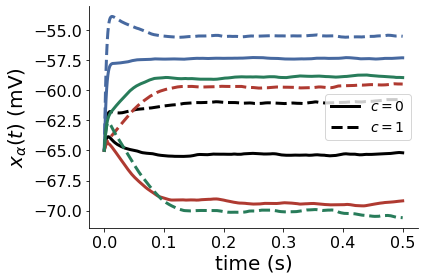

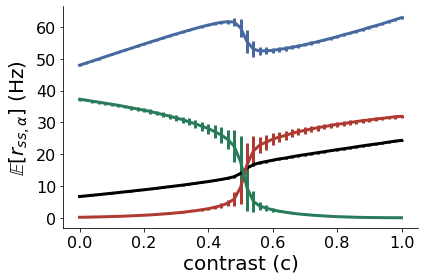

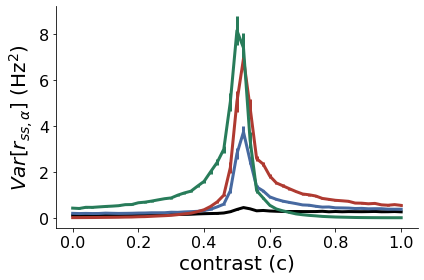

In [134]:
v_t = plot_responses(z_mode1[0], N=200, dt=0.001, T=2000, fontsize=20)

In [90]:
b = z[:,:4]
hc = z[:,4:]
dh = hc*np.concatenate((np.ones((1,2)), np.zeros((1,2))), axis=1)

r_t1s = np.mean(f_r(SSSN_sim_traj(b, N=5, dt=0.001, T=2000)).numpy(), axis=1)
r_t2s = np.mean(f_r(SSSN_sim_traj(b + dh, N=5, dt=0.001, T=2000)).numpy(), axis=1)

SV_diff1 = (r_t1s[:,2,-1] - r_t1s[:,3,-1])
SV_diff2 = (r_t2s[:,2,-1] - r_t2s[:,3,-1])

[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


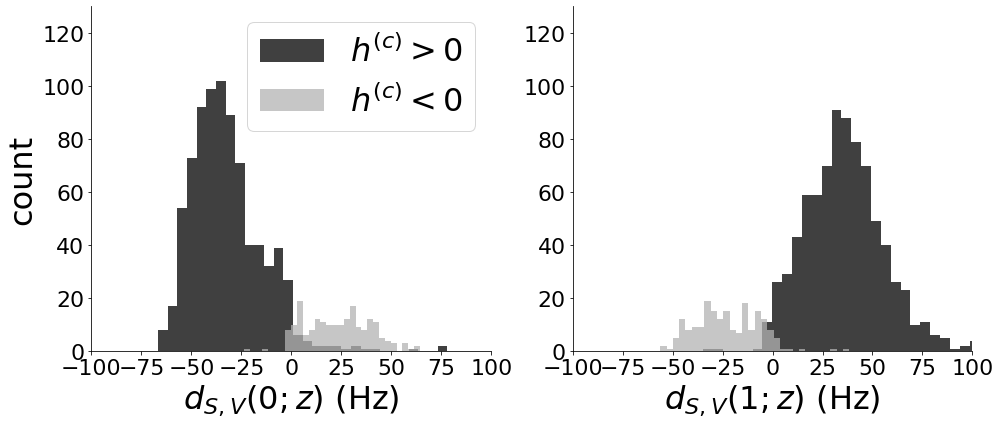

In [137]:
nbins = 30

label1 = r'$h^{(c)} > 0$'
label2 = r'$h^{(c)} < 0$'

fontsize = 32
alpha = 0.75
xlims = [-100, 100]
ylims = [0,130]

fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].hist(SV_diff1[hc[:,0] > 0.], nbins, color='k', alpha=alpha, label=label1)
axs[0].hist(SV_diff1[hc[:,0] < 0.], nbins, color=.7*np.ones((3,)), alpha=alpha, label=label2)
axs[0].set_xlabel(r'$d_{S,V}(0; z)$ (Hz)', fontsize=fontsize)
axs[0].set_ylabel("count", fontsize=fontsize)
axs[0].legend(fontsize=fontsize)
axs[0].set_xlim(xlims)
axs[0].set_ylim(ylims)
plt.setp(axs[0].get_xticklabels(), fontsize=(fontsize-10))
plt.setp(axs[0].get_yticklabels(), fontsize=(fontsize-10))
axs[1].hist(SV_diff2[hc[:,0] > 0.], nbins, color='k', alpha=alpha, label=label1)
axs[1].hist(SV_diff2[hc[:,0] < 0.], nbins, color=.7*np.ones((3,)), alpha=alpha, label=label2)
axs[1].set_xlabel(r'$d_{S,V}(1; z)$ (Hz)', fontsize=fontsize)
axs[1].set_xlim(xlims)
axs[1].set_ylim(ylims)
plt.setp(axs[1].get_xticklabels(), fontsize=(fontsize-10))
plt.setp(axs[1].get_yticklabels(), fontsize=(fontsize-10))
print(axs[1].get_yticklabels())
plt.tight_layout()
plt.savefig(figdir + "SVflip_sim_diffs.png")
plt.show()

In [ ]:
fac = 10
npzfile = np.load("data/V1_Zs.npz")
_W = npzfile["Z_allen_square"][None, :, :]
_W[:, :, 1:] = -_W[:, :, 1:]
W_E = fac*_W[0,0,:]

def V1_sim(h, dh):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]

    n = 2.
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    npzfile = np.load("data/V1_Zs.npz")
    _W = npzfile["Z_allen_square"][None, :, :]
    _W[:, :, 1:] = -_W[:, :, 1:]
    W = fac*tf.constant(_W, dtype=tf.float32)

    def f(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    r_t = euler_sim_traj(f, x_init, dt, T)
    return r_t

def ISN_coeff(z):
    h = z[:,:4]
    dh = z[:,4:]

    r_ts = V1_sim(h, 0.*dh)
    r_ss = r_ts[:,:,-1].numpy()
    h_E = h[:,0]
    u_E = np.dot(W_E, r_ss.T) + h_E
    u_E[u_E < 0.] = 0.
    ISN_coeff1 = 1.-2*(u_E)*W_E[0]
    
    r_ts = V1_sim(h, dh)
    r_ss = r_ts[:,:,-1].numpy()
    h_E = h[:,0] + dh[:,0]
    u_E = np.dot(W_E, r_ss.T) + h_E
    u_E[u_E < 0.] = 0.
    ISN_coeff2 = 1.-2*(u_E)*W_E[0]
    
    return ISN_coeff1, ISN_coeff2

ISN_coeff1, ISN_coeff2 = ISN_coeff(z)

In [ ]:
plt.figure()
plt.hist(ISN_coeff1)
plt.show()

plt.figure()
plt.hist(ISN_coeff2)
plt.show()
